In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#pd.options.display.float_format = '{:.3f}'.format

In [2]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_validate
from sklearn.preprocessing import StandardScaler,RobustScaler

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,confusion_matrix,classification_report

In [5]:
from sklearn.metrics import roc_curve,roc_auc_score,mean_squared_error,r2_score,plot_roc_curve, plot_confusion_matrix

In [6]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirebilir misiniz?


## Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır. Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

                # Değişkenler
                # Pregnancies: Hamilelik sayısı
                # Glucose: Glikoz.
                # BloodPressure: Kan basıncı.
                # SkinThickness: Cilt Kalınlığı
                # Insulin: İnsülin.
                # BMI: Beden kitle indeksi.
                # DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
                # Age: Yaş (yıl)
                # Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

### Yapılacaklar : 
                    # 1. Exploratory Data Analysis
                    # 2. Data Preprocessing
                    # 3. Model & Prediction
                    # 4. Model Evaluation
                    # 5. Model Validation: Holdout
                    # 6. Model Validation: 10-Fold Cross Validation
                    # 7. Prediction for A New Observation


In [7]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):            # q1 ve q3'e dikkat
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [8]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [9]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Exploratory Data Analysis

In [10]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

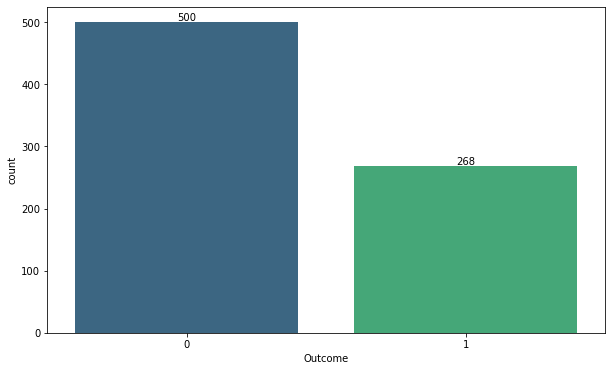

In [11]:
ax = sns.countplot(x ="Outcome",data=df,palette="viridis")
for container in ax.containers:
    ax.bar_label(container)

In [12]:
df["Outcome"].value_counts(normalize=True) * 100

0   65.104
1   34.896
Name: Outcome, dtype: float64

<AxesSubplot:>

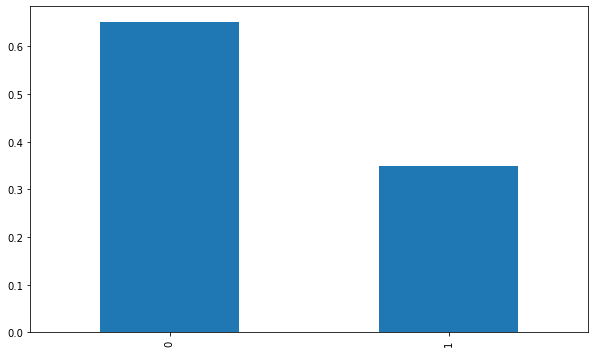

In [13]:
df["Outcome"].value_counts(normalize=True).plot.bar()

In [14]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [15]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


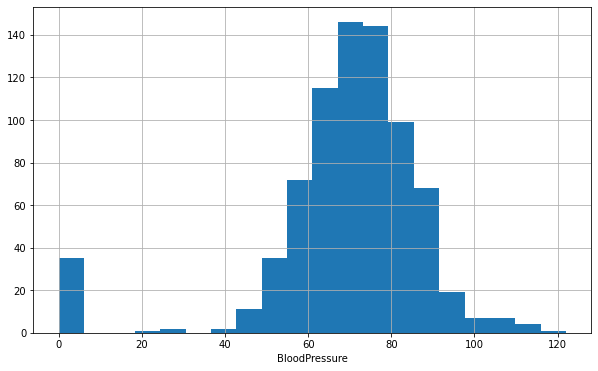

In [17]:
df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.show()

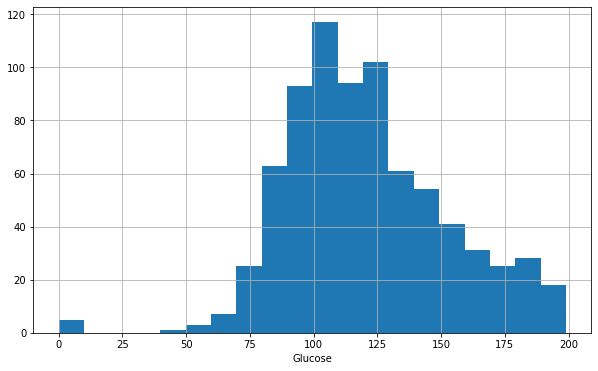

In [18]:
df["Glucose"].hist(bins=20)
plt.xlabel("Glucose")
plt.show()

In [19]:
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)               # ------------> grafikler üst üste binmesin diye block =True

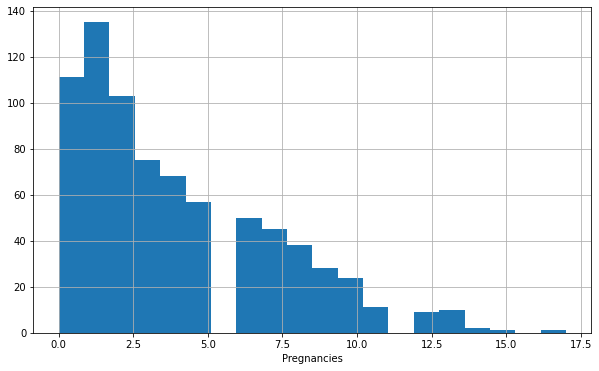

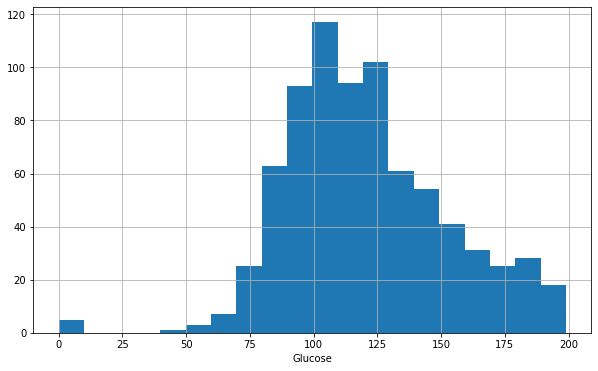

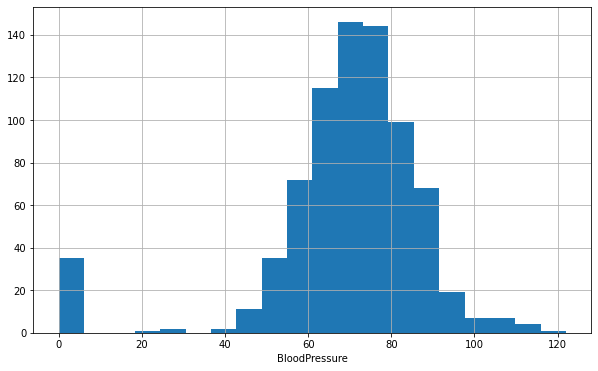

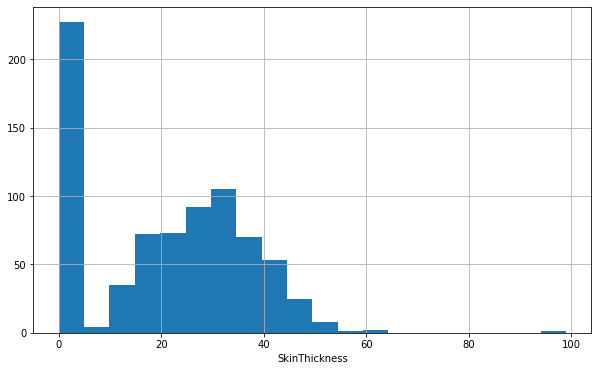

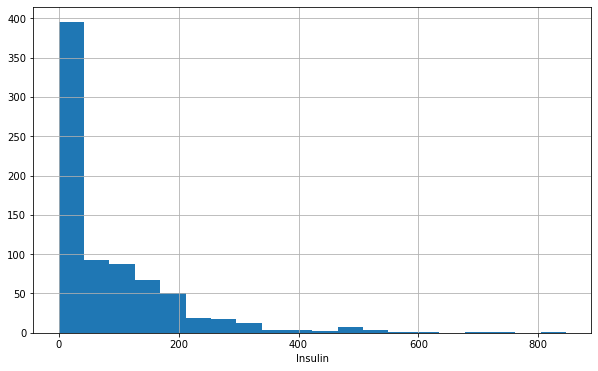

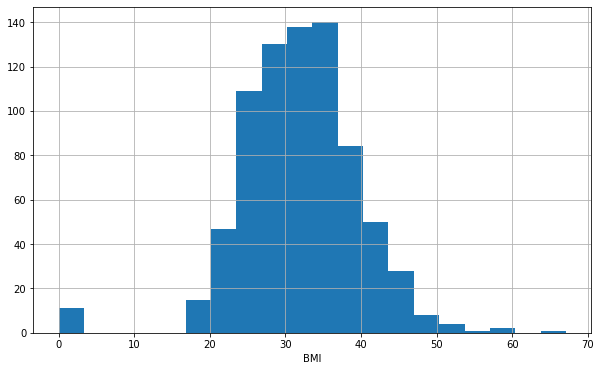

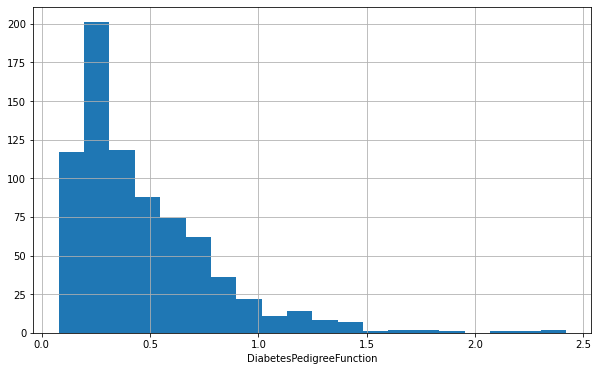

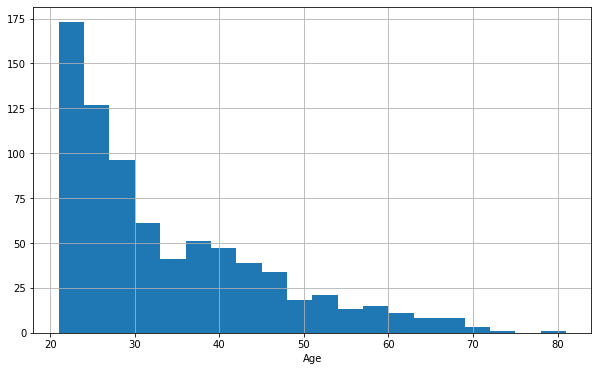

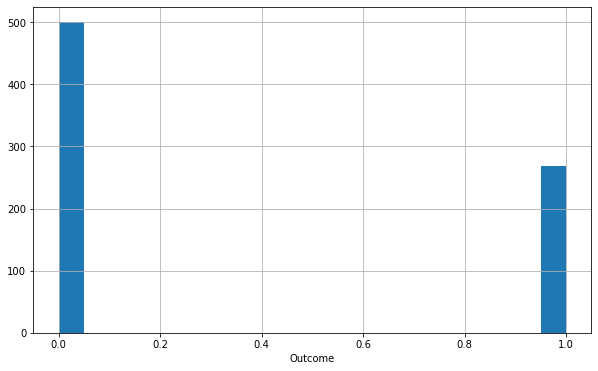

In [20]:
for col in df.columns:
    plot_numerical_col(df, col)

In [21]:
cols = [col for col in df.columns if "Outcome" not in col]          # target'ı görmek istemezsek : 

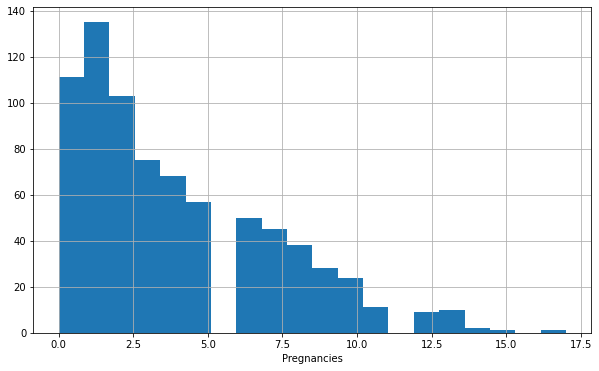

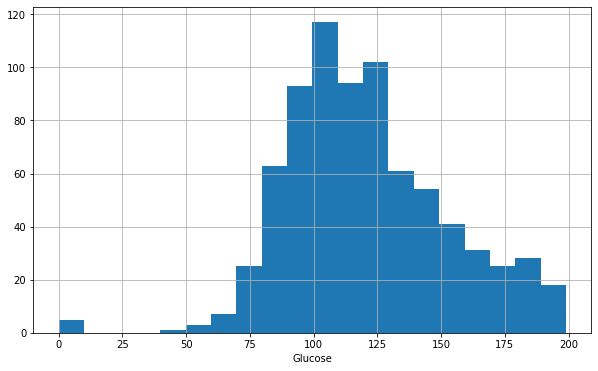

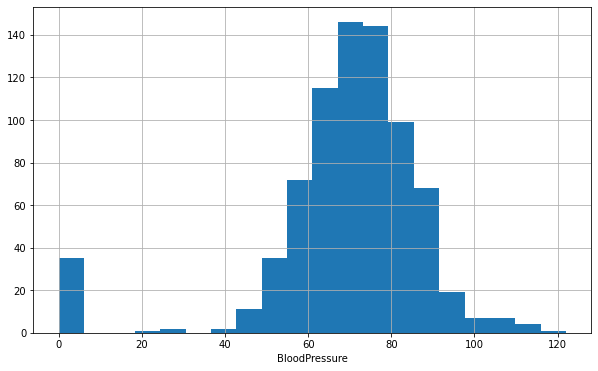

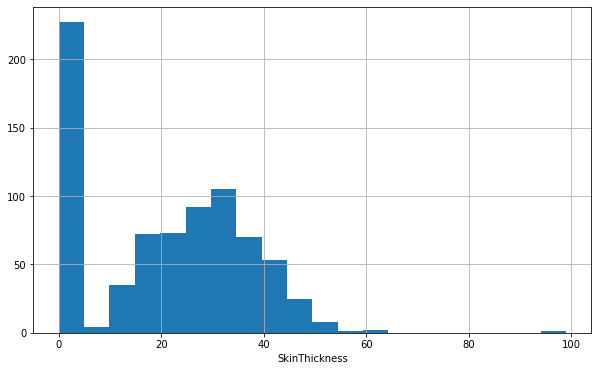

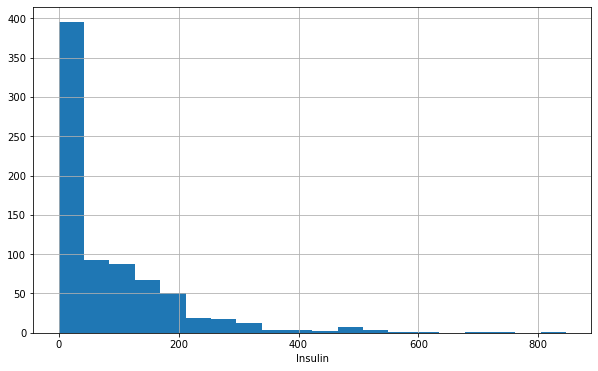

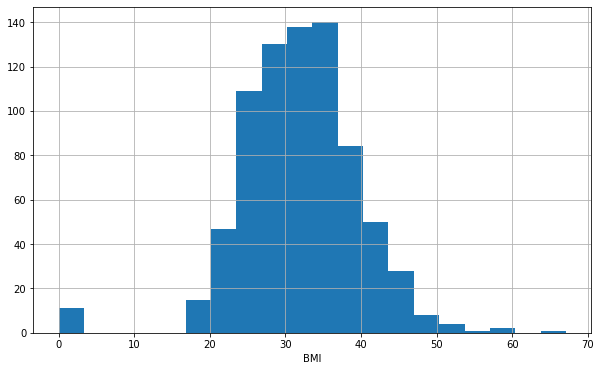

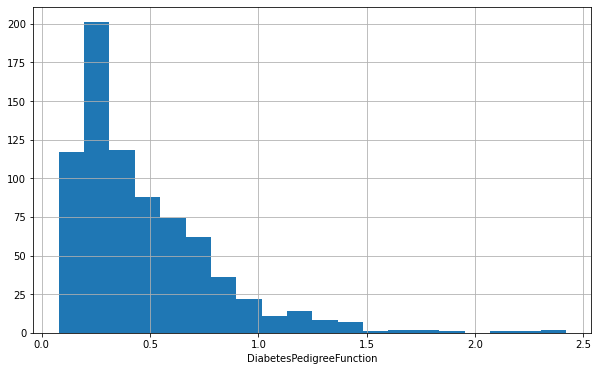

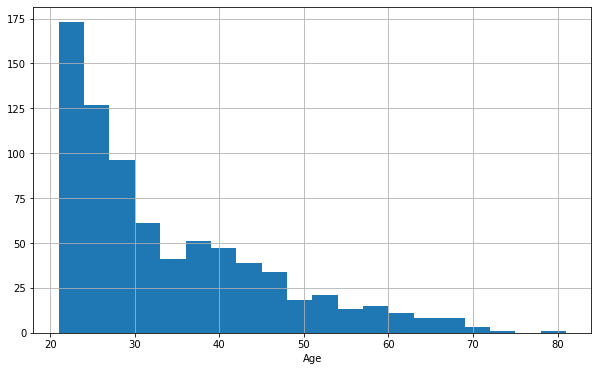

In [22]:
for col in cols:
    plot_numerical_col(df, col)

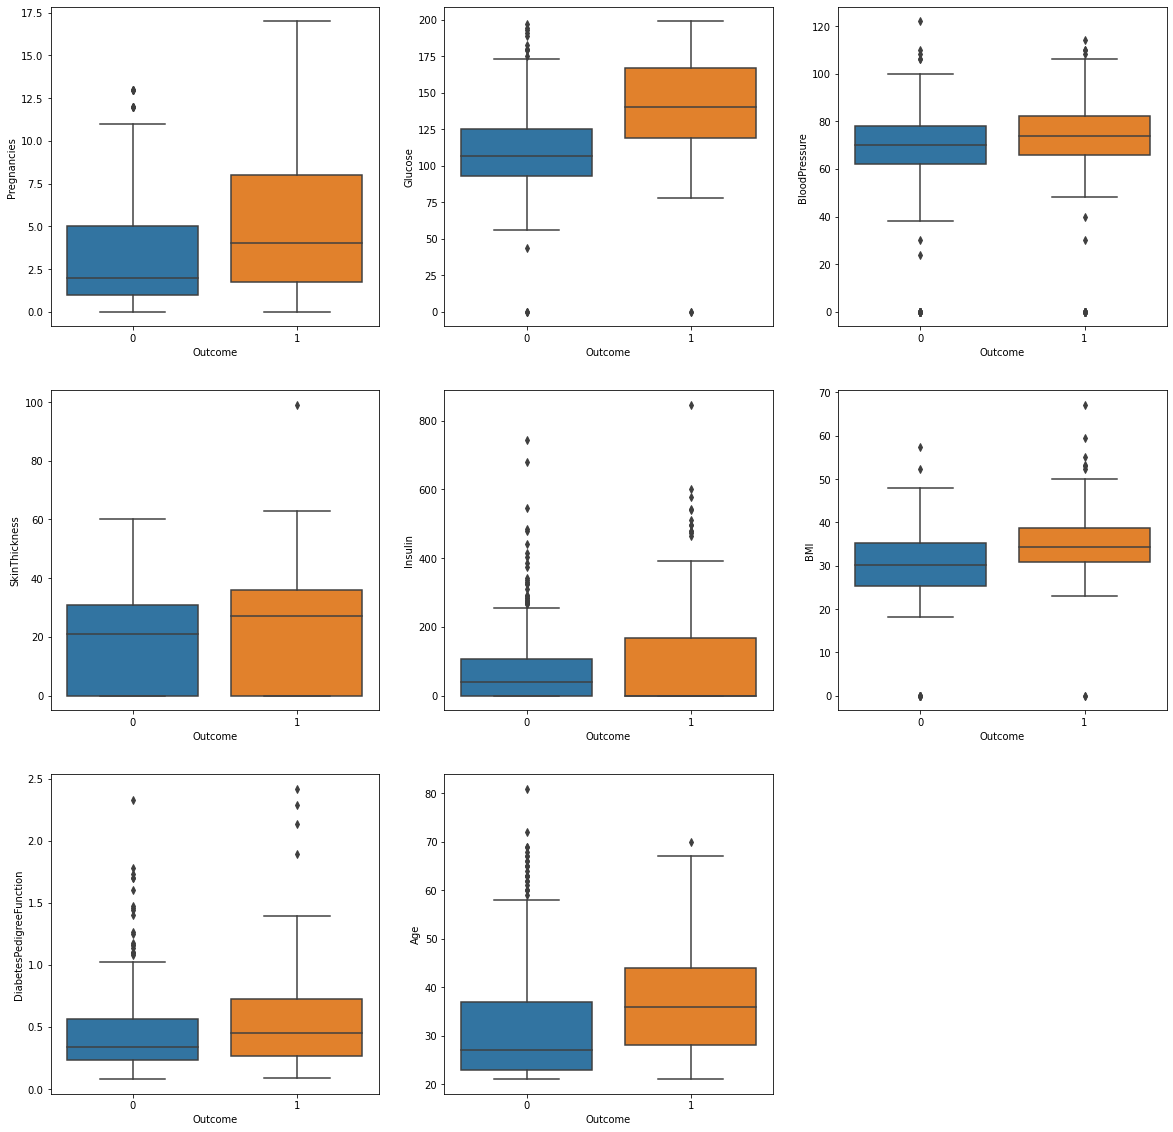

In [23]:
index = 0
plt.figure(figsize=(20,20))
for feature in df.columns:
    if feature != "Outcome":
        index += 1
        plt.subplot(3,3,index)
        sns.boxplot(x='Outcome',y=feature,data=df)

<AxesSubplot:>

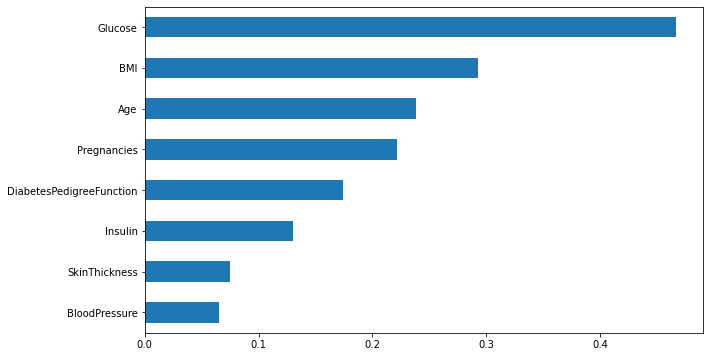

In [24]:
df.corr()["Outcome"].drop("Outcome").sort_values().plot.barh()

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [26]:
df.loc[df["Pregnancies"] == 17]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
159,17,163,72,41,114,40.900,0.817,47,1


In [27]:
df[df["BMI"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.000,0.232,54,1
49,7,105,0,0,0,0.000,0.305,24,0
60,2,84,0,0,0,0.000,0.304,21,0
81,2,74,0,0,0,0.000,0.102,22,0
145,0,102,75,23,0,0.000,0.572,21,0
371,0,118,64,23,89,0.000,1.731,21,0
426,0,94,0,0,0,0.000,0.256,25,0
494,3,80,0,0,0,0.000,0.174,22,0
522,6,114,0,0,0,0.000,0.189,26,0
684,5,136,82,0,0,0.000,0.640,69,0


In [28]:
df[df["BloodPressure"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115,0,0,0,35.300,0.134,29,0
15,7,100,0,0,0,30.000,0.484,32,1
49,7,105,0,0,0,0.000,0.305,24,0
60,2,84,0,0,0,0.000,0.304,21,0
78,0,131,0,0,0,43.200,0.270,26,1
81,2,74,0,0,0,0.000,0.102,22,0
172,2,87,0,23,0,28.900,0.773,25,0
193,11,135,0,0,0,52.300,0.578,40,1
222,7,119,0,0,0,25.200,0.209,37,0
261,3,141,0,0,0,30.000,0.761,27,1


In [81]:
df[df["SkinThickness"] == 0].count()

Pregnancies                 22
Glucose                     22
BloodPressure               22
SkinThickness               22
Insulin                     22
BMI                         22
DiabetesPedigreeFunction    22
Age                         22
Outcome                     22
dtype: int64

# Target vs Features

In [29]:
df.groupby("Outcome").agg({"Pregnancies": "mean"})

,Pregnancies
Outcome,
0,3.298
1,4.866


In [30]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [31]:
for col in cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




# Data Preprocessing (Veri Ön İşleme)

In [32]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [33]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


## missing_valulelar sanki 0 ile doldurulmuş. aslında yoğunlaşarak bunları NaN yapıp doldurmak daha uygun.

In [35]:
for col in cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


### biz q1 ve q3'ü değiştirdik nedeni : sadece ucundan en fazla olanlara dokunalım gibi.çok değişkenli bir etki olabilir diye.

In [36]:
replace_with_thresholds(df, "Insulin")         # fazla True olsaydı döngüye alırdık.

In [37]:
for col in cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [38]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0.000,33.600,0.627,50,1
1,1,85,66,29,0.000,26.600,0.351,31,0
2,8,183,64,0,0.000,23.300,0.672,32,1
3,1,89,66,23,94.000,28.100,0.167,21,0
4,0,137,40,35,168.000,43.100,2.288,33,1


## bu yapılanda data leakage olabilir bir de data leakage'ı engelleyerek çözmekte yarar var.

In [39]:
for col in cols: #bağımsızlar.
    df[col] = RobustScaler().fit_transform(df[[col]])    # robust-------> outlierlara karşı dayanıklı.

In [40]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


# Model & Prediction

In [41]:
y = df["Outcome"]

In [42]:
X = df.drop(["Outcome"], axis=1)

In [43]:
log_model = LogisticRegression().fit(X, y)

In [44]:
log_model.intercept_

array([-1.23439588])

In [45]:
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [46]:
y_pred = log_model.predict(X)

In [47]:
y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

In [48]:
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

## burada bütün veriyle model kuruldu bütün veriyle bir değerlendirme yapıldı bu sıkıntılı bir durum.

# Model Evaluation

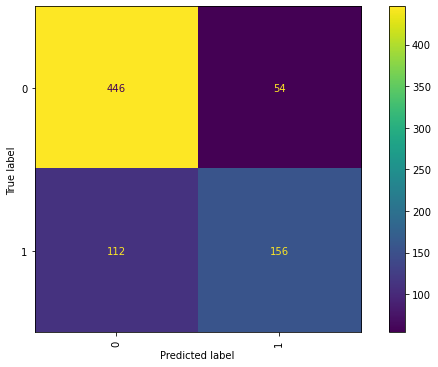

In [49]:
plot_confusion_matrix(log_model, X, y,xticks_rotation="vertical");       

In [50]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



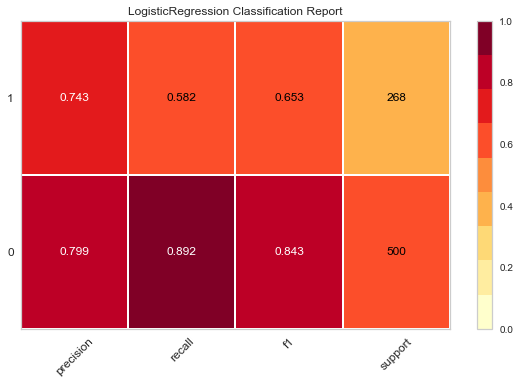

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [51]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(log_model,support=True)

visualizer.fit(X, y)        # Fit the visualizer and the model
visualizer.score(X, y)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

# ROC AUC  : farklı thresholda göre oluşabilecek başarılara yönelik genel bir metric.

In [52]:
y.shape

(768,)

In [53]:
y_prob = log_model.predict_proba(X)
y_prob

array([[0.28359381, 0.71640619],
       [0.94894448, 0.05105552],
       [0.21158782, 0.78841218],
       ...,
       [0.82688728, 0.17311272],
       [0.71234466, 0.28765534],
       [0.92538489, 0.07461511]])

In [54]:
log_model.classes_

array([0, 1], dtype=int64)

In [55]:
y_prob.shape                 # -------> 1 sınıfının gerçekleşme olasılıkları ve 0 sınıfının gerçekleşme olasılıkları

(768, 2)

In [56]:
y_prob = log_model.predict_proba(X)[:, 1]    # --------> sınıf 1'in gerçekleşme olasılığının tahim değerleri
y_prob

array([0.71640619, 0.05105552, 0.78841218, 0.04367789, 0.89752376,
       0.14920746, 0.06908148, 0.63435631, 0.70658734, 0.03863606,
       0.22219307, 0.89165049, 0.77944549, 0.65935946, 0.62425143,
       0.39662625, 0.37318974, 0.19866947, 0.35703823, 0.23711181,
       0.3930209 , 0.3192061 , 0.93636117, 0.29468743, 0.69739181,
       0.43942323, 0.73098803, 0.04800202, 0.53661347, 0.28012375,
       0.42776085, 0.56949791, 0.05108714, 0.03839617, 0.43121533,
       0.15293469, 0.65819897, 0.3937366 , 0.17535934, 0.57262782,
       0.73613722, 0.69062599, 0.1174309 , 0.92351316, 0.62263968,
       0.9490217 , 0.43165427, 0.04184679, 0.37968488, 0.04025223,
       0.03814319, 0.08782561, 0.06990396, 0.82257852, 0.70382787,
       0.02403838, 0.87770227, 0.36040116, 0.82871081, 0.18605478,
       0.01057618, 0.51752669, 0.0249713 , 0.30863948, 0.354305  ,
       0.1215789 , 0.19663257, 0.47275093, 0.03377323, 0.30252771,
       0.19654497, 0.36306089, 0.81091235, 0.24827821, 0.05400

In [57]:
y_prob.shape

(768,)

## thresholdlar değişerek elde ediliyor bu değerler ayrıca şunu da unutmayalım bu thresholdlara göre hesaplamalar yapılıyor roc eğrisinde ve auc'de

In [58]:
roc_auc_score(y, y_prob)          # 1sınıfının gerçekleşme olasılıkları ile ilgilendik burada dikkat : auc scoru döndü

0.8393955223880598

## aldığımız sonuçları doğrulamak lazım çünkü modeli eğittiğimiz set ile test yaptık bunu doğrulamamız gerekecek :

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

In [60]:
y_train.shape

(614,)

In [61]:
y_test.shape

(154,)

In [62]:
log_model = LogisticRegression()
log_model

LogisticRegression()

In [63]:
log_model.fit(X_train,y_train)

LogisticRegression()

In [64]:
y_pred = log_model.predict(X_test)
y_pred

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)

In [65]:
y_pred.shape

(154,)

In [66]:
y_prob = log_model.predict_proba(X_test)[:, 1]
y_prob

array([0.06804212, 0.67362318, 0.15580225, 0.04115179, 0.22638023,
       0.43013794, 0.12701295, 0.79226746, 0.68292189, 0.78866052,
       0.69662761, 0.80288574, 0.13490687, 0.34575988, 0.14099292,
       0.13085956, 0.61420479, 0.15645542, 0.23147392, 0.25430899,
       0.78882317, 0.14551328, 0.04506302, 0.86731296, 0.34282373,
       0.20787647, 0.84258175, 0.01771794, 0.6548531 , 0.28856996,
       0.85053315, 0.32086825, 0.08155495, 0.10163576, 0.24474319,
       0.03774459, 0.76384136, 0.46241654, 0.05351762, 0.57510688,
       0.05112654, 0.05187473, 0.15240088, 0.95510929, 0.03464702,
       0.31139817, 0.72175728, 0.33397601, 0.63178928, 0.45530048,
       0.28943527, 0.04520906, 0.42362836, 0.37393817, 0.50028372,
       0.71740476, 0.29559   , 0.18998347, 0.38165279, 0.09060687,
       0.27784606, 0.18514527, 0.17436361, 0.67764698, 0.20620011,
       0.06686608, 0.2565223 , 0.2421511 , 0.37481733, 0.22976379,
       0.70913772, 0.13838746, 0.22106238, 0.07364074, 0.03165

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



## train datası ile eğitim ve test yapınca sonuçlarımız şöyleydi. :
# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65

## model görmediği veride zannetiğimiz kadar başarılı değil gibi cv ile buna odaklanabiliriz.

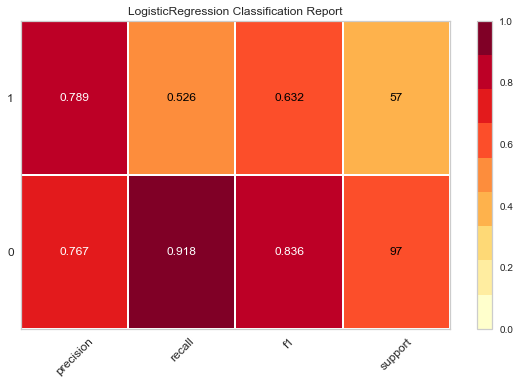

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [68]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(log_model,support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

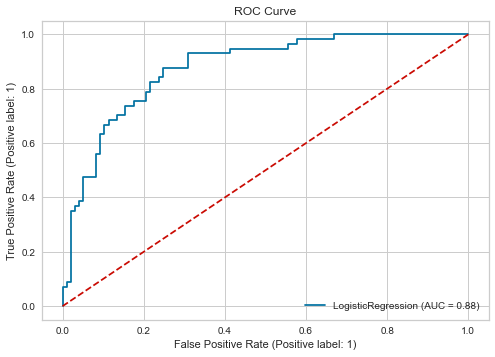

In [69]:
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [70]:
# AUC
roc_auc_score(y_test, y_prob)             # bunu hemen üstteki grafikte de görebiliyoruz.

0.8755652016639537

# önceki auc değeri 0.84 idi

## auc daha yüksek çıktı recall daha düşük çıktı bunun için cv gerekiyor .

# Model Validation: 5-Fold Cross Validation

In [71]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [72]:
log_model = LogisticRegression().fit(X, y)             # train test split de yapılabilir.

In [73]:
cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],)
cv_results

{'fit_time': array([0.00615048, 0.0039978 , 0.00459957, 0.00439835, 0.00650668]),
 'score_time': array([0.00527978, 0.00609708, 0.00501037, 0.00515008, 0.00499964]),
 'test_accuracy': array([0.77272727, 0.74675325, 0.75324675, 0.81699346, 0.77124183]),
 'test_precision': array([0.71111111, 0.64705882, 0.71052632, 0.79069767, 0.73684211]),
 'test_recall': array([0.59259259, 0.61111111, 0.5       , 0.64150943, 0.52830189]),
 'test_f1': array([0.64646465, 0.62857143, 0.58695652, 0.70833333, 0.61538462]),
 'test_roc_auc': array([0.81277778, 0.80888889, 0.825     , 0.87339623, 0.84358491])}

In [74]:
pd.DataFrame(cv_results, index = range(1,6))

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
1,0.006,0.005,0.773,0.711,0.593,0.646,0.813
2,0.004,0.006,0.747,0.647,0.611,0.629,0.809
3,0.005,0.005,0.753,0.711,0.500,0.587,0.825
4,0.004,0.005,0.817,0.791,0.642,0.708,0.873
5,0.007,0.005,0.771,0.737,0.528,0.615,0.844


In [75]:
scores = pd.DataFrame(cv_results, index=range(1,6))
scores.iloc[:, 2:].mean()    

test_accuracy    0.772
test_precision   0.719
test_recall      0.575
test_f1          0.637
test_roc_auc     0.833
dtype: float64

In [76]:
# modelimizin gerçek skorları cv ile alınır.

                önceki değerler
                            # Accuracy: 0.78
                            # Precision: 0.74
                            # Recall: 0.58               --------> bütün veri
                            # F1-score: 0.65

                            # Accuracy: 0.77
                            # Precision: 0.79             -----------> train test ayırarak
                            # Recall: 0.53
                            # F1-score: 0.63

# Prediction for A New Observation

In [77]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [78]:
random_user = X.sample(1, random_state=42)
random_user

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
668,0.600,-0.461,-0.778,0.312,1.253,0.215,0.150,0.824


In [79]:
log_model.predict(random_user)

array([0], dtype=int64)